In [1]:
#import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
import graphviz
import config
import pipeline

%matplotlib inline

## 1. Read Data

First, we will read the dataset and the data dictionary for the dataset.

In [2]:
# Read the dataset
df = pipeline.read_data(config.PIPELINE_CONFIG['dataset'])

############################################################

Data Shape: (41016, 12)

Descritive Statistics:

       SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines           age  \
count  41016.000000      41016.00000                           41016.000000   
mean   0.161400          6.37587                               51.683489      
std    0.367904          221.61895                             14.746880      
min    0.000000          0.00000                               21.000000      
25%    0.000000          0.03431                               41.000000      
50%    0.000000          0.18973                               51.000000      
75%    0.000000          0.66716                               62.000000      
max    1.000000          22000.00000                           109.000000     

            zipcode  NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  \
count  41016.000000  41016.000000                          41016.000000    
mean   60623.824166  0.58

In [3]:
# Read the data dictionary
data_dict = pipeline.read_data(config.PIPELINE_CONFIG['data_dict'])

############################################################

Data Shape: (12, 3)

Descritive Statistics:

           Variable Name              Description     Type
count   12                12                       12     
unique  12                12                       5      
top     SeriousDlqin2yrs  zipcode of the borrower  integer
freq    1                 1                        7      

############################################################



In [4]:
data_dict.head(12)

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,zipcode,zipcode of the borrower,interget/string
5,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
6,MonthlyIncome,Monthly income,real
7,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
8,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
9,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer


## 2. Exploratory Data Analysis

We will look at distributions of variables, correlations between them, and summarize data.

### The Distribution of the Outcome Variable

The Outcome Variable: __*SeriousDlgin2yrs*__

Count of values in SeriousDlqin2yrs:

0    34396
1    6620 
Name: SeriousDlqin2yrs, dtype: int64



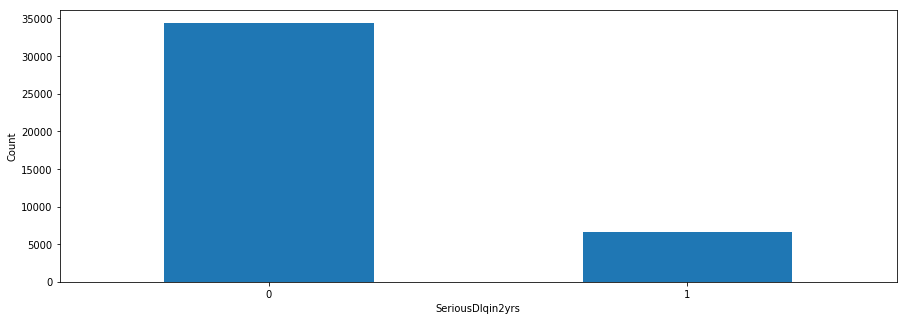

In [5]:
pipeline.view_variable_freq(df, config.PIPELINE_CONFIG['outcome_var'])

There are an imbalance in the outcome variable. Specifically, there are far more people who experienced 90 days past due delinquency or worse.

### Missing Values

Now we find variables that have missing values.

In [6]:
# Check the missing data
nan_vars = pipeline.find_var_with_missing_values(df)

                                       NaN  Percent of NaN
MonthlyIncome                         7974  19.44         
NumberOfDependents                    1037  2.53          
SeriousDlqin2yrs                      0     0.00          
RevolvingUtilizationOfUnsecuredLines  0     0.00          
age                                   0     0.00          
zipcode                               0     0.00          
NumberOfTime30-59DaysPastDueNotWorse  0     0.00          
DebtRatio                             0     0.00          
NumberOfOpenCreditLinesAndLoans       0     0.00          
NumberOfTimes90DaysLate               0     0.00          
NumberRealEstateLoansOrLines          0     0.00          
NumberOfTime60-89DaysPastDueNotWorse  0     0.00          

The following variables have missing values: ['MonthlyIncome', 'NumberOfDependents']

- MonthlyIncome has 7974.0 missing values, which are 19.44% of the entire data

- NumberOfDependents has 1037.0 missing values, which are 2.53% of

- We can see that there are a lot of missing data for __MonthlyIncome__ and __NumberOfDependents__.
- We will store __MonthlyIncome__ and __NumberOfDependents__ as a list: __nan_vars__.
- Therefore, we probably do not want to simply drop all missing data.

First, we will look at the distribution of __MonthlyIncome__ and __NumberOfDependents__.

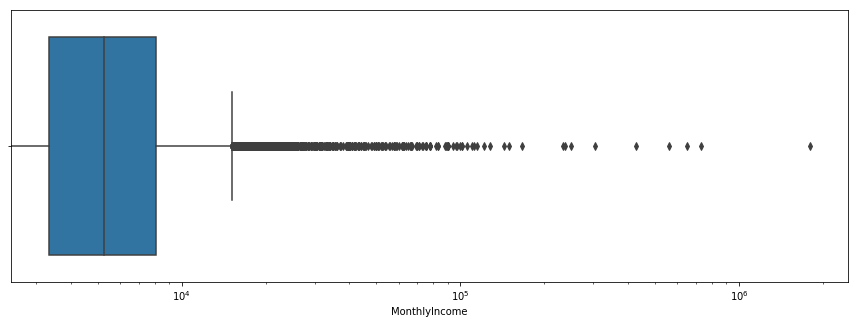

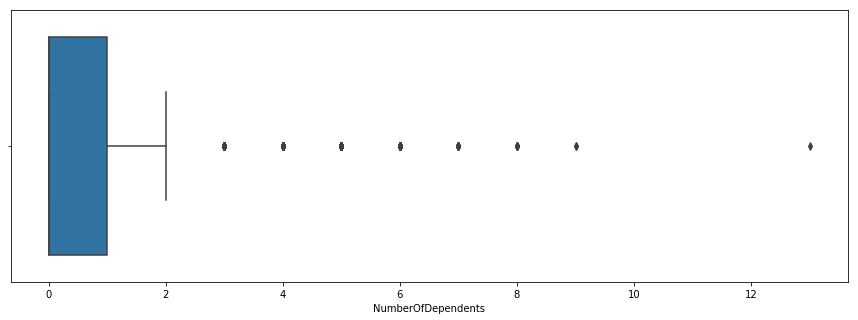

In [7]:
pipeline.generate_boxplots(df, nan_vars)

As we can see from these boxplots, the distribution of __MonthlyIncome__ is very skewed.
- For __MonthlyIncome__, which is very *skewed*, we will use median to impute NaN.
- For __NumberOfDependents__, we will use mean to impute NaN.

### Correlations between Variables

Next, we will examine correlations between variables to detect any patterns.

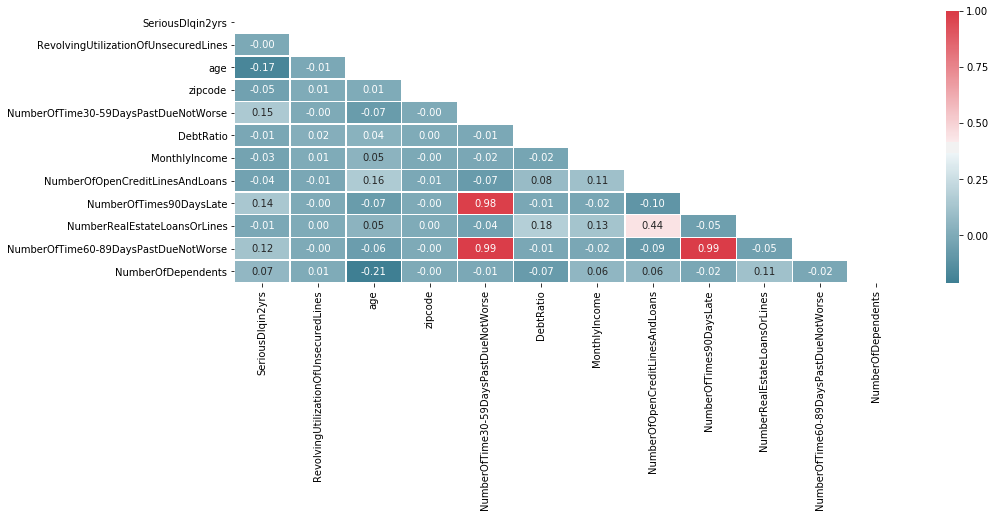

In [8]:
pipeline.generate_corr_heatmap(df)

From this heatmap, we can see that the following variables:
- __NumberOfTime30-59DaysPastDueNotWorse__,
- __NumberOfTimes90DaysLate__,
- __NumberOfTime60-89DaysPastDueNotWorse__

have extremely high correlations amongst one another (0.98 - 0.99). We should consider dropping variables from machine learning training.

### Finding Outliers

Next, we will see if there are any outliers. To detect outliers, we will use __*1.5xIQR Rule*__.

Basically, we will say that any points below Q1 - 1.5IQR or above Q3 + 1.5IQR are outliers.

We will look at the following variables (selected based on the correlation with the outcome variable) and check if they have any outliers.
- __age__
- __NumberOfTimes90DaysLate__

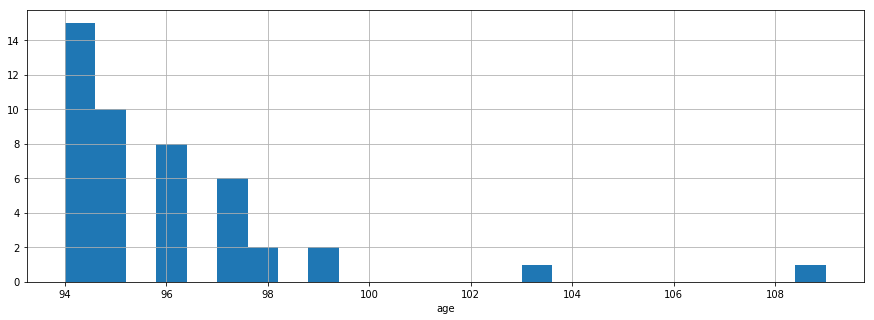

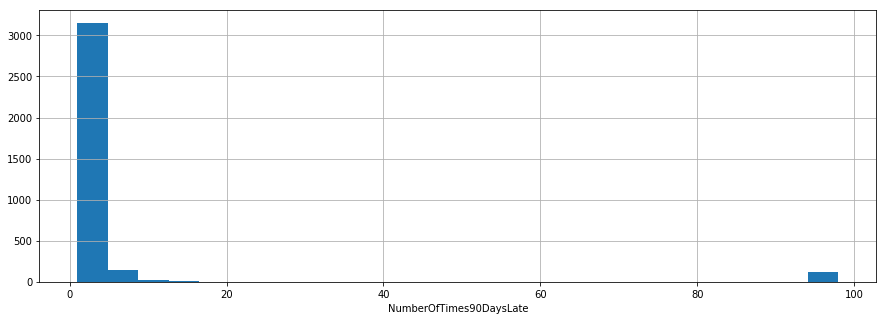

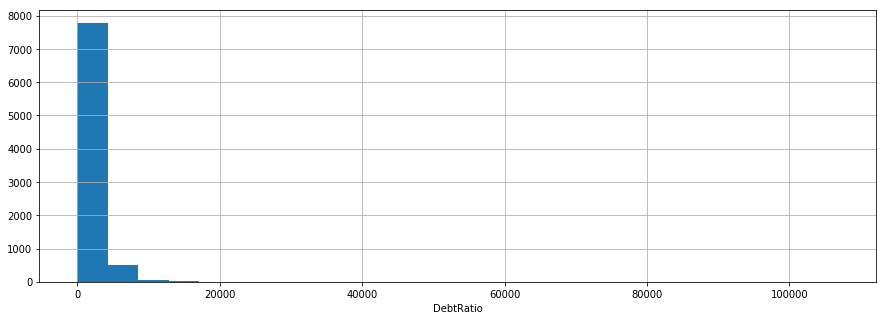

In [9]:
pipeline.visualize_outliers(df, ['age', 'NumberOfTimes90DaysLate', 'DebtRatio'])

Although all three variables seem to have outliers, these outliers do not seem to be *impossible*. Therefore, we will keep these values for now.

## 3. Pre-process the data

### Imputation

We aim to fill the missing values in our dataset. If the variable is extremely skewed, we will use the median to fill the missing data. Otherwise, we will use the mean.

In [10]:
pipeline.impute_missing_data(df, nan_vars)

For MonthlyIncome, median is selected.
For NumberOfDependents, mean is selected.
Imputation completed!


### Drop highly correlated variables

As we saw from the heatmap, __NumberOfTimes90DaysLate__ is highly correlated with __NumberOfTime60-89DaysPastDueNotWorse__ and __NumberOfTime30-59DaysPastDueNotWorse__. We will drop __NumberOfTimes90DaysLate__ and __NumberOfTime60-89DaysPastDueNotWorse__ since __NumberOfTime30-59DaysPastDueNotWorse__ has the highest correlation with the outcome variable.

In [11]:
drop_vars = ['NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']
pipeline.drop_variable(df, drop_vars)

['NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'] are successfully dropped from the dataset


## 4. Generate Features/Predictors



We will discretize __age__ and __debt_ratio__ and make those into dummy variables.

In [12]:
#age
age_labels = ['Child', 'YoungAdult', 'Adult', 'Elderly']
pipeline.discretize_variable(df, 'age', 4, labels=age_labels)
df = pipeline.generate_dummy(df, 'age_cat')

In [13]:
#debt_ratio
ratio_labels = ['LowRatio', 'MiddleRatio', 'HighRatio', 'VeryHighRatio']
pipeline.discretize_variable(df, 'DebtRatio', 4, labels=ratio_labels)
df = pipeline.generate_dummy(df, 'DebtRatio_cat')

## 5. Build / Evaluate Classifier

We will build a classifier with __*DecisionTreeClassifier*__.

1. Split the dataset into outcome set and feature set and split into training and test sets.


In [15]:
X_train, X_test, y_train, y_test = pipeline.create_X_y_set(df)

2. Fit into the Decision Tree model.

In [16]:
dectree = DecisionTreeClassifier(criterion='gini', random_state=config.PIPELINE_CONFIG['random_state'])
dectree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

3. Evaluate the decision tree model and find the best max_depth for the model.

In [17]:
pipeline.evaluate_decision_tree_model(dectree, X_test, y_test)

The calculated accuracy of this model is 0.7973


We will change __max_depth__ of the model to find the best max depth for the decision tree.

In [18]:
pipeline.find_best_max_depth(X_train, y_train, X_test, y_test)

### max_depth: 1
The calculated accuracy of this model is 0.7887
---------------
### max_depth: 2
The calculated accuracy of this model is 0.8552
---------------
### max_depth: 3
The calculated accuracy of this model is 0.8518
---------------
### max_depth: 4
The calculated accuracy of this model is 0.8527
---------------
### max_depth: 5
The calculated accuracy of this model is 0.8585
---------------
### max_depth: 6
The calculated accuracy of this model is 0.8592
---------------
### max_depth: 7
The calculated accuracy of this model is 0.8548
---------------
### max_depth: 8
The calculated accuracy of this model is 0.8532
---------------
### max_depth: 9
The calculated accuracy of this model is 0.8498
---------------


From this, we know that the best max_depth for this decision tree classifier is __*6*__ with the accuracy of __0.8592__.

4. Build and visualize the Decision Tree model with the best max_depth.

In [21]:
best_dt = DecisionTreeClassifier(criterion='gini', max_depth=6,
                                 random_state=config.PIPELINE_CONFIG['random_state'])
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

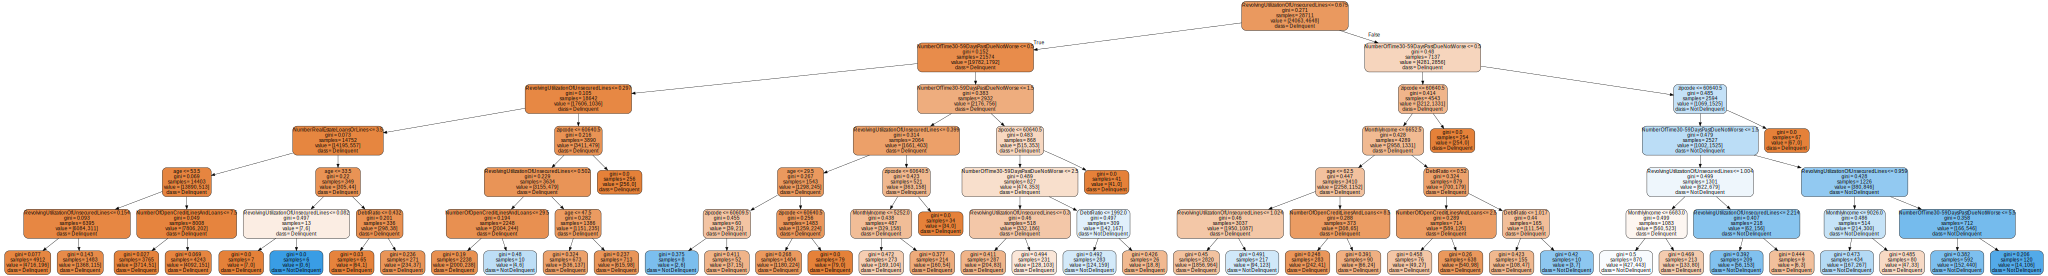

In [27]:
viz = export_graphviz(best_dt, feature_names=X_train.columns, out_file='data/tree.dot',
                      class_names=['Delinquent', 'Not Delinquent'],
                      rounded=True, filled=True)

with open('data/tree.dot') as f:
    dot_graph = f.read()
    graph = graphviz.Source(dot_graph)

graph

__*From our analysis of the dataset, the decision tree classifier visualized above trained with a max depth of 6 had the highest accuracy of 0.8592.*__